In [14]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import meshio

In [15]:
# Constants
permittivity = 100
sigma = 1
V0 = 100.0  # Voltage amplitude
omega = 1.0  # Frequency in Hz
num_steps = 50  # Time steps
dt = 1 / (20 * omega)

In [16]:
# Mesh Generation
def generate_mesh(geo_file, mesh_scale_factor,output_mesh):
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.option.setNumber("Mesh.CharacteristicLengthFactor", mesh_scale_factor)
    gmsh.model.mesh.generate(2)
    gmsh.write(output_mesh)
    gmsh.finalize()

def read_mesh(filename):
    mesh = meshio.read(filename)
    nodes = mesh.points[:, :2]
    elements = mesh.cells_dict["triangle"]
    return nodes, elements


In [17]:
# Gaussian Quadrature Points and Weights
gaussian_points = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
weights = np.array([1/6, 1/6, 1/6])

# Assemble Matrices
def assemble_matrices(nodes, elements):
    num_nodes = nodes.shape[0]
    K = np.zeros((num_nodes, num_nodes))
    M = np.zeros((num_nodes, num_nodes))
    F = np.zeros(num_nodes)

    for iel, elem in enumerate(elements):
        econ = elem
        coord = nodes[econ]
        # region_id = regions[iel]

        K_elem = np.zeros((3, 3))
        M_elem = np.zeros((3, 3))

        for gp_idx in range(len(gaussian_points)):
            pt = gaussian_points[gp_idx]
            w = weights[gp_idx]

            # Shape function gradients and Jacobian
            dN = np.array([[-1, -1], [1, 0], [0, 1]])
            J = dN.T @ coord
            det_J = np.linalg.det(J)
            inv_J = np.linalg.inv(J)

            B = inv_J @ dN.T

            K_elem += (B.T @ B) * sigma * det_J * w
            M_elem += (B.T @ B) * permittivity * det_J * w
        # print(K_elem_1, K_elem_2)
        for a in range(3):
            for b in range(3):
                K[econ[a], econ[b]] += K_elem[a, b]
                M[econ[a], econ[b]] += M_elem[a, b]

    return K, M, F


In [18]:
def solve_implicit_scheme(K, M, F,nodes):
    num_nodes = K.shape[0]
    phi = np.zeros(num_nodes)
    A = M + K*dt
    y_0_cord = np.zeros((num_nodes,), dtype=bool)
    y_1_cord = np.zeros((num_nodes,), dtype=bool)
    for node_num in range(nodes.shape[0]):
        if nodes[node_num][1] == 0:
            y_0_cord[node_num]= True
        if nodes[node_num][1] == 1:
            y_1_cord[node_num]= True

    for step in range(num_steps):
        F_temp = F.copy()
        K_temp = A.copy()
        t = step * dt
        top_voltage = V0 * np.sin(omega * t)
        rhs = F_temp*dt + M @ phi
        phi[y_0_cord] = 0
        phi[y_1_cord] = top_voltage
        phi[(~y_0_cord) & (~y_1_cord)] = np.linalg.inv(K_temp[(~y_0_cord) & (~y_1_cord)][:,(~y_0_cord) & (~y_1_cord)]).dot(rhs[(~y_0_cord) & (~y_1_cord)] - K_temp[(~y_0_cord) & (~y_1_cord)][:, ~((~y_0_cord) & (~y_1_cord))].dot(phi[~((~y_0_cord) & (~y_1_cord))]))

    return phi

In [19]:
def mesh_convergence(geo_file, mesh_factors, node_indices):
    errors = []
    prev_solution = None  # To store the solution from the previous mesh

    for factor in mesh_factors:
        # Generate and read mesh
        output_mesh = f"mesh_{factor:.2e}.msh"
        generate_mesh(geo_file, factor, output_mesh)
        nodes, elements = read_mesh(output_mesh)
        print(f"Mesh Factor: {factor:.2e}, Number of Nodes: {nodes.shape[0]}, Number of Elements: {elements.shape[0]}")

        # Assemble matrices
        K, M, F = assemble_matrices(nodes, elements)

        # Solve implicit scheme
        phi = solve_implicit_scheme(K, M, F,nodes)

        # Extract solution at specified nodes
        selected_phi = phi[node_indices]

        if prev_solution is not None:
            # Compute relative error
            error = np.linalg.norm(selected_phi - prev_solution) / np.linalg.norm(prev_solution)
            errors.append(error)
            print(error)
            # Update the previous solution
            
        else:
            # No error for the first solution
            errors.append(0)

        # Update the previous solution
        prev_solution = selected_phi

    return errors


Mesh Factor: 1.00e-02, Number of Nodes: 6827, Number of Elements: 13351

Mesh Factor: 2.00e-02, Number of Nodes: 2106, Number of Elements: 4054
0.001919448570822793

Mesh Factor: 5.00e-02, Number of Nodes: 502, Number of Elements: 925
0.005412362606964564

Mesh Factor: 7.00e-02, Number of Nodes: 358, Number of Elements: 653
0.01715717238518125


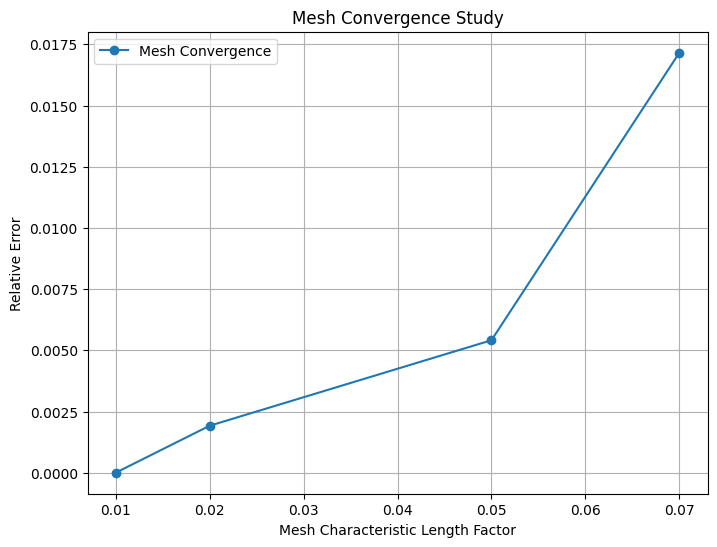

In [20]:
# Main Execution
geo_file = "R-25-0.geo"
mesh_factors = np.array([0.01,0.02,0.05,0.07])  # Example mesh size factors
node_indices = np.arange(0, 113) 
errors = mesh_convergence(geo_file, mesh_factors, node_indices)

# Plot Mesh Convergence
plt.figure(figsize=(8, 6))
plt.plot(mesh_factors, errors, marker='o', label="Mesh Convergence")
plt.xlabel("Mesh Characteristic Length Factor")
plt.ylabel("Relative Error")
plt.grid(True)
plt.legend()
plt.title("Mesh Convergence Study")
plt.show()

In [23]:
mesh_size_factors = [0.01]

for scale in mesh_size_factors:
    output_mesh = f"mesh{scale:.2e}.msh"
    generate_mesh(geo_file, scale,output_mesh)
    nodes, elements = read_mesh("generated_mesh.msh")
    phi = np.zeros(len(nodes))
    K, M, F = assemble_matrices(nodes, elements)
    phi = solve_implicit_scheme(K, M, F, nodes)
    print("Final Potential at nodes:", phi)


Final Potential at nodes: [ 0.         20.69800158 22.8084671  46.41243117 48.14431378 63.77647021
 48.1588408  46.42695819 47.39956072 22.86459746 20.75413194 22.32062353
 19.61760997 21.18410156 19.92568944 63.77647021 63.77647021 55.71843856
 54.95915848 55.95593946 38.32528868  0.         39.2978912  37.78131475
  0.          0.          0.         54.72116162 55.7179426  40.00245174
 38.48587528 55.35580509 38.98888132 63.77647021 21.1023097  19.84389758
 63.77647021 20.20656596 12.2491003  45.40156724 24.16630676 11.59645198
 46.0362107  44.38799682 24.6693128  12.61176867 23.27056302  7.85793332
 46.4600299   8.87325002 44.81181601  7.91733488  0.         45.33388369
  0.         26.62079326 25.22204349 50.3269476  25.84689844 63.77647021
 49.2008014  50.41471766 63.77647021 32.38460848 32.90667616 31.61071365
 13.57856042 12.62264528 15.7959033  13.04369198 16.42075825 15.26103486
 47.54017258 48.75408883 47.83424351  0.          0.45635687 34.31795146
  0.87740357 33.02198895

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_potential_contour(nodes, elements, phi):
    """
    Plot the contour of the potential distribution.
    """
    plt.figure(figsize=(8, 6))
    triangulation = Triangulation(nodes[:, 0], nodes[:, 1], elements)
    plt.tricontourf(triangulation, phi, levels=100, cmap="viridis")
    plt.colorbar(label="Potential (V)")
    plt.title("Contour Plot of Potential Distribution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.axis("equal")
    plt.show()


def plot_potential_3d(nodes, phi):
    """
    Plot the 3D surface of the potential distribution.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(nodes[:, 0], nodes[:, 1], phi, cmap="viridis", edgecolor="none")
    ax.set_title("3D Surface Plot of Potential Distribution")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Potential (V)")
    plt.show()


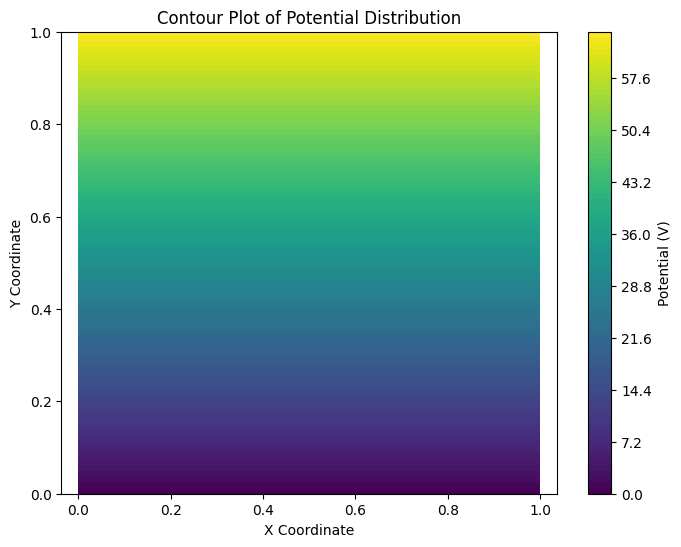

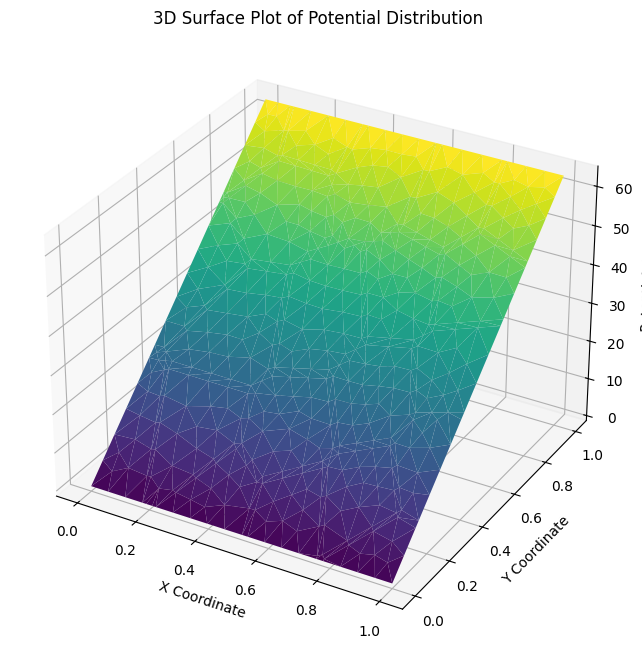

In [25]:
phi = phi = solve_implicit_scheme(K, M, F, nodes)

plot_potential_contour(nodes,elements,phi)

plot_potential_3d(nodes,phi)